In [1]:
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)

import matplotlib.pyplot as plt

from saved_class_Animator import Animator
from saved_class_Timer import Timer
from saved_class_Accumulator import Accumulator

Tensorflow Version:  2.4.1


## 17.1.1. Generate some "real" data

In [2]:
X = tf.random.normal(shape = (1000, 2), mean = 0.0, stddev = 1.0)
A = tf.constant([[1, 2], [-0.1, 0.5]])
b = tf.constant([1,2], dtype = tf.float32)
data = tf.matmul(X, A) + b

The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


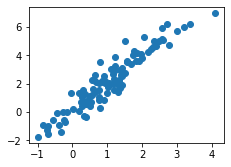

In [3]:
plt.figure(figsize = (3.5, 2.5))
plt.scatter(data[:100, 0], data[:100, 1])
print(f'The covariance matrix is\n{tf.matmul(A, A, transpose_a = True)}')
plt.show()

In [4]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator."""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

In [5]:
batch_size = 8
data_iter = load_array((data,), batch_size)

## 17.1.2. Generator

In [6]:
net_G = tf.keras.layers.Dense(2)

## 17.1.3. Discriminator

In [7]:
net_D = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation = "tanh", input_shape = (2,)),
    tf.keras.layers.Dense(3, activation = "tanh"),
    tf.keras.layers.Dense(1)
])

## 17.1.4. Training

In [8]:
def update_D(X, Z, net_D, net_G, loss, optimizer_D):  # In the book, last argument of this function is `trainer_D`. But we prefer `optimizer_D`.
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = tf.ones((batch_size,)) # Labels corresponding to real data
    zeros = tf.zeros((batch_size,)) # Labels corresponding to fake data
    fake_X = net_G(Z)
    with tf.GradientTape() as tape:
        real_Y = net_D(X)
        fake_Y = net_D(fake_X)
        # We multiply the loss by batch_size to match PyTorch's BCEWithLogitsLoss
        loss_D = (loss(ones, tf.squeeze(real_Y)) + loss(zeros, tf.squeeze(fake_Y))) * batch_size / 2
    grads_D = tape.gradient(loss_D, net_D.trainable_variables)
    optimizer_D.apply_gradients(zip(grads_D, net_D.trainable_variables))
    return loss_D

In [9]:
def update_G(Z, net_D, net_G, loss, optimizer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = tf.ones((batch_size,))
    with tf.GradientTape() as tape:
        # We could reuse `fake_X` from `update_D` to save computation
        fake_X = net_G(Z)
        # Recomputing `fake_Y` is needed since `net_D` is changed
        fake_Y = net_D(fake_X)
        # We multiply the loss by batch_size to match PyTorch's BCEWithLogits loss
        loss_G = loss(ones, tf.squeeze(fake_Y)) * batch_size
    grads_G = tape.gradient(loss_G, net_G.trainable_variables)
    optimizer_G.apply_gradients(zip(grads_G, net_G.trainable_variables))
    return loss_G

In [10]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction = tf.keras.losses.Reduction.SUM)
    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean = 0, stddev = 0.02, shape = w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean = 0, stddev = 0.02, shape = w.shape))
    optimizer_D = tf.keras.optimizers.Adam(learning_rate= lr_D)
    optimizer_G = tf.keras.optimizers.Adam(learning_rate= lr_G)
    animator = Animator(xlabel = "epoch", ylabel = "loss", xlim = [1, num_epochs],
                        nrows = 2, figsize = (5, 5), legend = ["discriminator", "generator"])
    animator.fig.subplots_adjust(hspace = 0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = Timer()
        metric = Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean = 0, stddev = 1, shape = (batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       update_G(Z, net_D, net_G, loss, optimizer_G), batch_size)
        # Visualize generated examples
        Z = tf.random.normal(mean = 0, stddev = 1, shape = (100, latent_dim))
        fake_X = net_G(Z)
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(["real", "generated"])
        
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
        
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

loss_D 0.693, loss_G 0.694, 650.8 examples/sec


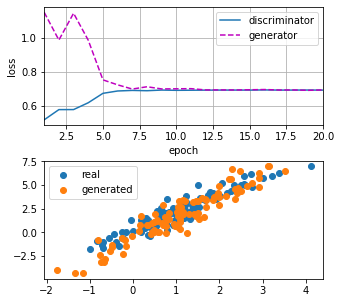

In [11]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data[:100])